In [1]:
import torch
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import plotnine as gg
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
import seaborn as sns
import tree
from data import rosetta_data_loader

import sys
import argparse
import re
import logging

import pandas as pd
pd.set_option('display.max_colwidth', None)

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

torch.hub.set_dir('/data/rsg/chemistry/jyim/.cache/torch')
plt.rcParams.update({'font.size': 14})

INFO: Using numpy backend


In [2]:
# Paths
base_dir = '/data/rsg/chemistry/jyim/paper/protdiff_icml/ablations'
samples_dir = os.path.join(base_dir, 'samples')
sample_cluster_dir = os.path.join(base_dir, 'sample_clustering')
figure_dir = os.path.join(base_dir, 'figures')
train_align_dir = os.path.join(base_dir, 'train_align')
train_pdbs_dir = os.path.join(base_dir, 'training_pdbs')


base_protdiff_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/'

os.makedirs(base_dir, exist_ok=True)
os.makedirs(train_align_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(train_pdbs_dir, exist_ok=True)
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(sample_cluster_dir, exist_ok=True)



if len(os.listdir(base_dir)):
    print('WARNING: overwriting results!')

In [3]:
def read_results(results_dir):
    all_csvs = []
    # results_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/baseline_0/25D_12M_2022Y_16h_24m_23s/unconditional/28D_12M_2022Y_23h_54m_42s'
    print(f'Reading samples from {results_dir}')
    for sample_length in os.listdir(results_dir):
        if '.' in sample_length:
            continue
        length_dir = os.path.join(results_dir, sample_length)
        for i,sample_name in enumerate(os.listdir(length_dir)):
            if '.' in sample_name:
                continue
            csv_path = os.path.join(length_dir, sample_name, 'mpnn', 'sc_results.csv')
            if os.path.exists(csv_path):
                design_csv = pd.read_csv(csv_path, index_col=0)
                design_csv['length'] = int(sample_length.split('_')[1])
                design_csv['sample_id'] = i
                all_csvs.append(design_csv)
    return pd.concat(all_csvs)
# no_self_condition_df = pd.concat(all_csvs)


In [4]:
# Successive ablations

no_dsm_df = read_results(
    '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/no_dsm_0/28D_01M_2023Y_18h_07m_05s/unconditional/ablation_no_dsm'
)


Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/no_dsm_0/28D_01M_2023Y_18h_07m_05s/unconditional/ablation_no_dsm


In [8]:
no_dsm_df['Ablation'] = 'No DSM loss'

In [ ]:
no_self_condition_df['Ablation'] = 'No self-conditioning'
no_dist_loss_df['Ablation'] = 'No 2D loss'
no_aux_loss_df['Ablation'] = 'No auxiliary loss'
no_x0_loss_df['Ablation'] = 'No x0 loss'
no_dsm_df['Ablation'] = 'No DSM loss'
ablations_df = pd.concat([no_self_condition_df, no_dist_loss_df, no_aux_loss_df, no_x0_loss_df, no_dsm_df])

In [ ]:
length_counts = no_x0_loss_df.length.value_counts()
length_counts = length_counts[length_counts < 80].reset_index()

In [ ]:
np.sort(no_aux_loss_df.length.unique())

In [31]:
890*9

8010

In [32]:
ablations_df.Ablation.value_counts()

No self-conditioning    9680
No 2D loss              9540
No auxiliary loss       8010
No x0 loss              7888
Name: Ablation, dtype: int64

In [33]:
np.sort(no_self_condition_df.length.unique())

array([ 60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120,
       125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185,
       190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250,
       255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315,
       320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380,
       385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445,
       450, 455, 460, 465, 470, 475, 480, 485, 490, 495])

# Process results

In [5]:
def pick_path(x):
    if x.sample_path is None or x.sample_path == '':
        return x.of_path
    return x.sample_path

length_categories = [
    '60-100', '100-200', '200-300', '300-400', '400-500'
][::-1]
buckets = np.arange(0, 501, 100)

def df_process(raw_df):
    # Process sample path
    df = raw_df.copy()
    df['sample_path'] = df['sample_path'].fillna('')
    df['sample_path'] = df.apply(pick_path, axis=1)
    df['sequence_id'] = df['sample_path'].apply(lambda x: int(os.path.basename(x).replace('.pdb', '').split('_')[1]))
    
    # Separate based on whether MPNNed
    df['header'] = df['header'].fillna('')
    df = df[df['header'].map(lambda x: 'sde_1' not in x)]
    return df

def sc_filter(raw_df, metric):
    # Pick best self-consistency sample
    if metric == 'rmsd':
        df = raw_df.sort_values('rmsd', ascending=True)
    elif metric == 'tm':
        df = raw_df.sort_values('tm_score', ascending=False)
    else:
        raise ValueError(f'Unrecognized metric: {metric}')
    df = df.groupby(['length', 'sample_id']).first().reset_index()

    # Separate into different length groups
    df['length_group'] = df.length.map(lambda x: length_categories[np.sum(x < buckets).item()-1])
    df['length_group'] = pd.Categorical(df['length_group'], ordered=True, categories=length_categories[::-1])

    # Calculate how designable
    cutoff = 0.5
    df['designable'] = df.tm_score.map(lambda x: x > cutoff)
    designable_df = pd.pivot_table(df, values='designable', index=['length_group', 'Ablation'], aggfunc=np.mean).reset_index()
    percent_designable = df['designable'].mean()
    print(f'Percent designable: {percent_designable}')
    return df, designable_df


def process_pipeline(raw_df, metric):
    processed_df = df_process(raw_df)
    seq_8_df = processed_df[(processed_df.sequence_id < 8) & (processed_df.length >=100)]
    df, designable = sc_filter(seq_8_df, metric=metric)
    return df, designable
    # designable['Sequences'] = 100
    # df['Sequences'] = 100
    # df_8, designable_8 = sc_filter(seq_8_df, metric=metric)
    # df_8['Sequences'] = 8
    # designable_8['Sequences'] = 8
    # samples_df = pd.concat([df, df_8], axis=0)
    # designable_df = pd.concat([designable, designable_8], axis=0)
    # return samples_df, designable_df


# Plot designable results

In [6]:
def plot_sc_rmsd(df, save_path=None):
    rmsd_samples, _ = process_pipeline(df, metric='rmsd')
    
    p = sns.boxplot(
        data=rmsd_samples,
        x='length_group',
        y='rmsd',
        hue='Ablation',
        showfliers=False
    )

    plt.xlabel('Length group')
    plt.ylabel('scRMSD')
    legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
    p.legend_.set_title('Ablation')
    plt.ylim(0.0, 25)
    if save_path is None:
        plt.show()
    else:
        # fig_path = os.path.join(figure_dir, 'unconditional_scrmsd_plt.png')
        plt.savefig(save_path, dpi=300)
        

def plot_sc_tm(df, save_path=None):
    tm_samples, tm_designable = process_pipeline(df, metric='tm')

    p = sns.boxplot(
        data=tm_samples,
        x='length_group',
        y='tm_score',
        hue='Ablation',
        showfliers = False
    )
    
    all_ablations = all_ablations_df.Ablation.unique().tolist()
    all_colors = ['blue', 'orange', 'green']
    for j,(color, ablation) in enumerate(zip(all_colors, all_ablations)):
        designable_numbers = tm_designable[
            tm_designable.Ablation == ablation].designable.tolist()
        for i,xtick in enumerate(p.get_xticks()):
            p.text(
                xtick,
                1.0 - j * 0.05,
                f"{designable_numbers[i]*100:2.1f}%\n",
                horizontalalignment='center',
                size='small',
                color=color,
                weight='semibold'
            )

    plt.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth=2, alpha=0.5)
    plt.ylim(0.0, 1.1)
    plt.xlabel('Length group')
    plt.ylabel('scTM')

    legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
    # p.legend_.set_title('ProteinMPNN \nsequences')

    if save_path is None:
        plt.show()
    else:
        # fig_path = os.path.join(figure_dir, 'unconditional_scrmsd_plt.png')
        plt.savefig(save_path, dpi=300)

# Plot

In [9]:
_ = process_pipeline(no_dsm_df, metric='tm')

Percent designable: 0.002551020408163265


In [38]:
_ = process_pipeline(no_self_condition_df, metric='tm')
_ = process_pipeline(no_dist_loss_df, metric='tm')
_ = process_pipeline(no_aux_loss_df, metric='tm')
# _ = process_pipeline(no_x0_loss_df, metric='tm')

Percent designable: 0.42375
Percent designable: 0.215
Percent designable: 0.1617283950617284


In [37]:
no_self_condition_df['Ablation'] = 'No self-conditioning'
no_dist_loss_df['Ablation'] = 'No 2D loss'
no_aux_loss_df['Ablation'] = 'No auxiliary loss'
no_x0_loss_df['Ablation'] = 'No x0 loss'

Percent designable: 0.5098765432098765


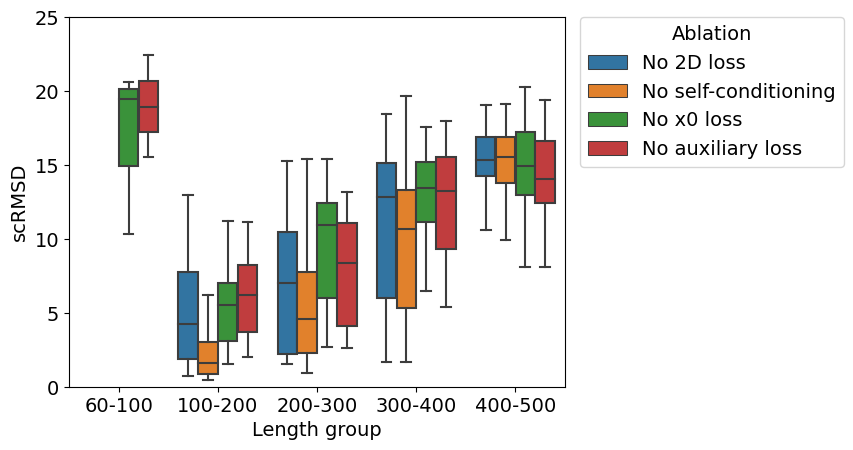

In [22]:
plot_sc_rmsd(ablations_df)

Percent designable: 0.5898876404494382


NameError: name 'all_ablations_df' is not defined

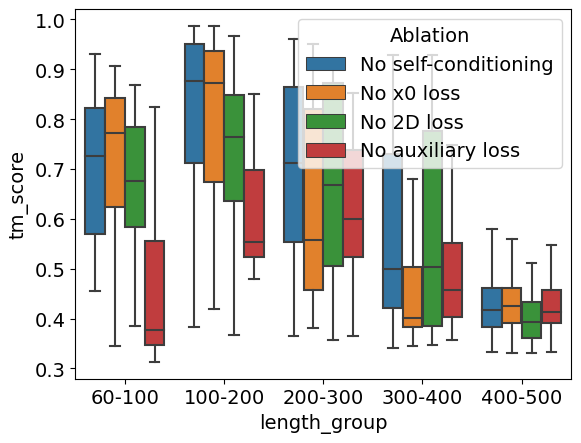

In [16]:
plot_sc_tm(ablations_df)

['No self-conditioning', 'No 2D distance loss', 'No x0 loss']

In [19]:
rmsd_samples, _ = process_pipeline(refolded_df, metric='rmsd')

Percent designable: 0.650561797752809
Percent designable: 0.5089887640449439


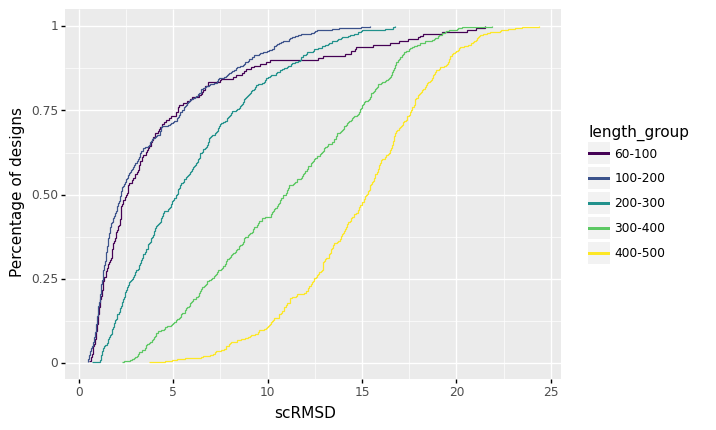

In [23]:
# Plot
p = (
    gg.ggplot(
        rmsd_samples,
        gg.aes('rmsd', color='length_group')
    )
    + gg.stats.stat_ecdf()
    # + gg.scales.scale_x_reverse()
    # + gg.geoms.geom_vline(
    #     xintercept=cutoff,
    #     size=1.0,
    #     linetype='dashed',
    #     color='red',
    # )
    + gg.labels.xlab('scRMSD')
    + gg.labels.ylab('Percentage of designs')
)

print(p)

## With self-conditioning

In [9]:
rmsd_samples, rmsd_designable = process_pipeline(self_conditioned_df, metric='rmsd')

Percent designable: 0.8549848942598187
Percent designable: 0.7613293051359517


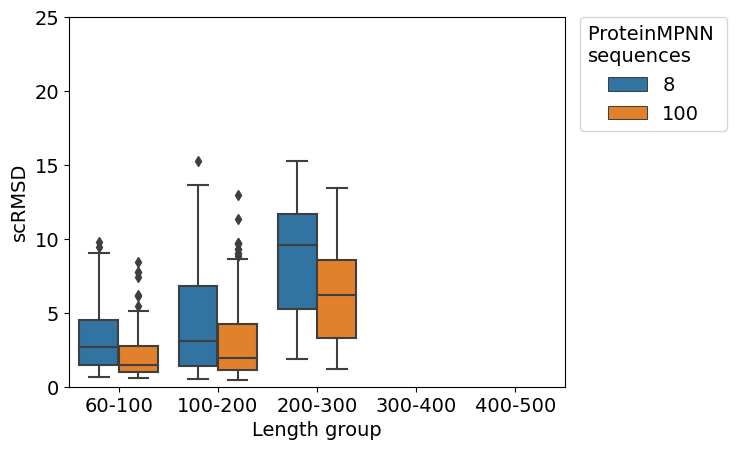

In [11]:
plt.rcParams.update({'font.size': 14})
p = sns.boxplot(
    data=rmsd_samples,
    x='length_group',
    y='rmsd',
    hue='Sequences',
)

plt.xlabel('Length group')
plt.ylabel('scRMSD')
legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
p.legend_.set_title('ProteinMPNN \nsequences')
plt.ylim(0.0, 25)
plt.show()
# fig_path = os.path.join(figure_dir, 'unconditional_scrmsd_plt.png')
# plt.savefig(fig_path, dpi=300)

In [12]:
tm_samples, tm_designable = process_pipeline(self_conditioned_df, metric='tm')

Percent designable: 0.879154078549849
Percent designable: 0.7885196374622356


In [14]:
tm_designable

,length_group,designable,Sequences
0,60-100,0.937500,100
1,100-200,0.890000,100
2,200-300,0.745098,100
0,60-100,0.837500,8
1,100-200,0.820000,8
2,200-300,0.588235,8


IndexError: list index out of range

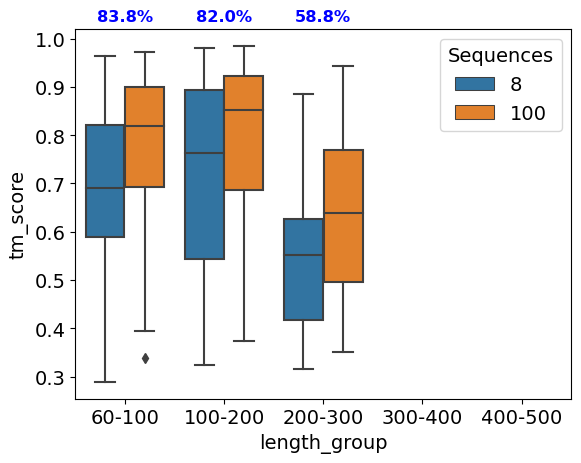

In [13]:
plt.rcParams.update({'font.size': 14})
p = sns.boxplot(
    data=tm_samples,
    x='length_group',
    y='tm_score',
    hue='Sequences'
)

designable_numbers = tm_designable[tm_designable.Sequences == 8].designable.tolist()
for i,xtick in enumerate(p.get_xticks()):
    p.text(
        xtick,
        1.0,
        f"{designable_numbers[i]*100:2.1f}%\n",
        horizontalalignment='center',
        size='small',
        color='blue',
        weight='semibold'
    )

designable_numbers = tm_designable[tm_designable.Sequences == 100].designable.tolist()
for i,xtick in enumerate(p.get_xticks()):
    p.text(
        xtick,
        0.95,
        f"{designable_numbers[i]*100:2.1f}%\n",
        horizontalalignment='center',
        size='small',
        color='orange',
        weight='semibold'
    )
    
plt.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth=2, alpha=0.5)
plt.ylim(0.0, 1.1)
plt.xlabel('Length group')
plt.ylabel('scTM')

legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
p.legend_.set_title('ProteinMPNN \nsequences')

plt.show()

# fig_path = os.path.join(figure_dir, 'unconditional_sctm_plt.png')
# plt.savefig(fig_path, dpi=300)

In [211]:
plt.rcParams.update({'font.size': 14})
p = sns.boxplot(
    data=hallucination_sc_df,
    x='length_group',
    y='rmsd',
)

# designable_numbers = designable_df.designable.tolist()
# for i,xtick in enumerate(p.get_xticks()):
#     p.text(
#         xtick,
#         1.05,
#         f"{designable_numbers[i]*100:2.1f}%",
#         horizontalalignment='center',
#         size='small',
#         color='red',
#         weight='semibold'
#     )
# plt.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth=2, alpha=0.5)
# plt.ylim(0.0, 1.1)
plt.xlabel('Length group')
plt.ylabel('scRMSD')
# plt.show()
fig_path = os.path.join(figure_dir, 'unconditional_scrmsd_plt.png')
plt.savefig(fig_path, dpi=300)

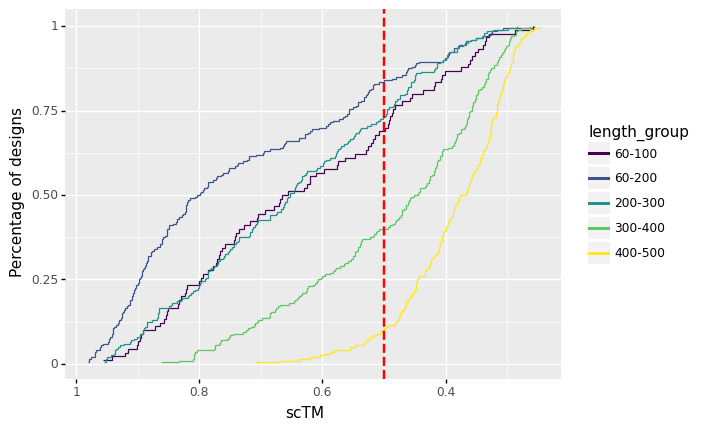

In [12]:
# Plot
p = (
    gg.ggplot(
        hallucination_sc_df,
        gg.aes('tm_score', color='length_group')
    )
    + gg.stats.stat_ecdf()
    + gg.scales.scale_x_reverse()
    + gg.geoms.geom_vline(
        xintercept=cutoff,
        size=1.0,
        linetype='dashed',
        color='red',
    )
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Percentage of designs')
)

print(p)

In [13]:
# Save out the figure
fig_path = os.path.join(figure_dir, 'cumulative_sctm.png')
p.save(filename=fig_path, dpi=300)

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_3/figures/cumulative_sctm.png


In [24]:
# Save all designable hallucination samples
designable_samples_df = hallucination_sc_df[hallucination_sc_df.designable]
# if os.path.isdir(all_samples_path):
#     shutil.rmtree(samples_path)
# os.makedirs(samples_path, exist_ok=True)
fname = os.path.join(samples_dir, 'sc_pdbs.txt')
prefix = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/13D_12M_2022Y_13h_43m_13s/'
with open(fname, 'w') as f:
    for _, row in designable_samples_df.iterrows():
        sample_path = row.sample_path
        full_path = os.path.join(base_protdiff_dir, sample_path)
        if 'hallucination/0' not in sample_path:
            full_path = full_path.replace('hallucination', 'hallucination/0')
        suffix = '/'.join(full_path.split('/')[-5:])
        full_path = os.path.join(prefix, suffix)
        file_name = f'length_{str(row.length)}_id_{str(row.sample_id)}.pdb'
        save_path = os.path.join(samples_dir, file_name)
        shutil.copy(full_path, save_path)
        f.write(save_path+'\n')

In [80]:
hallucination_sc_df.designable.sum()

475

# Compare with Rfdiffusion

In [7]:
# Format RF diffusion samples
s2f_df = pd.read_csv('S2F_data.csv')
s2f_df['Unconditional'] = s2f_df.problem.apply(lambda x: 'uncond' in x)
rfdiff_samples_df = s2f_df[s2f_df['Unconditional']]
metric = 'rmsd_af2_des'
df_temp = rfdiff_samples_df.sort_values(metric)
df_temp = df_temp.drop_duplicates('name')

cols = [
    'rmsd_af2_des',
    'problem',
    'random',
]
formatted_rf_diff = {
    'length': rfdiff_samples_df.problem.apply(lambda x: int(x.split('_')[1])),
    'rmsd': rfdiff_samples_df.rmsd_af2_des,
    'model': rfdiff_samples_df.random.map({
        'Outputs without Pre-Training': 'RFDiffusion w/o pretraining',
        'Outputs with Pre-Training': 'RFDiffusion',
    }),
}
formatted_rf_diff = pd.DataFrame(formatted_rf_diff)


/tmp/ipykernel_2330880/3773061146.py:2: DtypeWarning: Columns (98,118,119,121,122,127,133,134,135,139,140) have mixed types. Specify dtype option on import or set low_memory=False.


In [12]:
# Format FrameDiff samples
# rmsd_samples, _ = process_pipeline(refolded_df, metric='rmsd')
rmsd_samples, _ = process_pipeline(self_conditioned_df, metric='rmsd')
rmsd_seq_8_samples = rmsd_samples[rmsd_samples.Sequences == 100]
formatted_framediff = rmsd_seq_8_samples[['length', 'rmsd']]
formatted_framediff = formatted_framediff[formatted_framediff.length.isin([70, 100, 200, 300])]
formatted_framediff['model'] = 'FrameDiff'

Percent designable: 0.8558823529411764
Percent designable: 0.7617647058823529


In [13]:
formatted_df = pd.concat([formatted_rf_diff, formatted_framediff], axis=0)

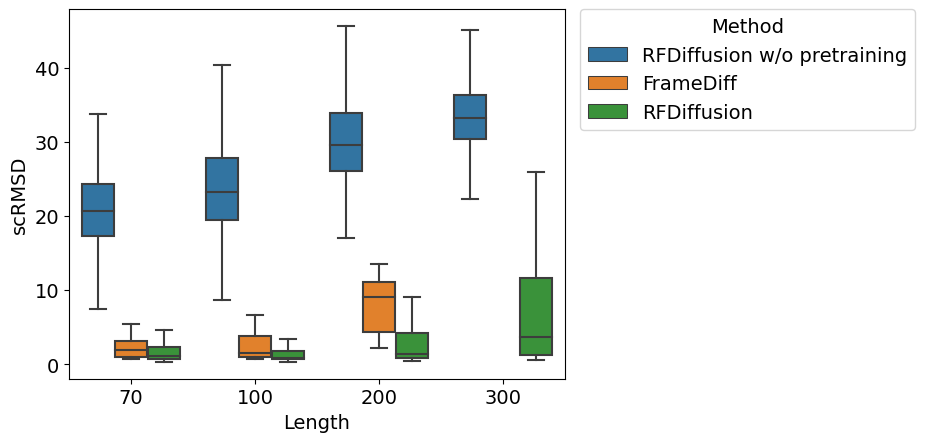

In [14]:
order = ['RFDiffusion w/o pretraining', 'FrameDiff', 'RFDiffusion']
ax = sns.boxplot(
    x = 'length',
    y = 'rmsd',
    data = formatted_df,
    hue = 'model',
    hue_order=order,
    showfliers = False
)

# plt.ylim(0.0, 1.1)
plt.xlabel('Length')
plt.ylabel('scRMSD')
legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
ax.legend_.set_title('Method')

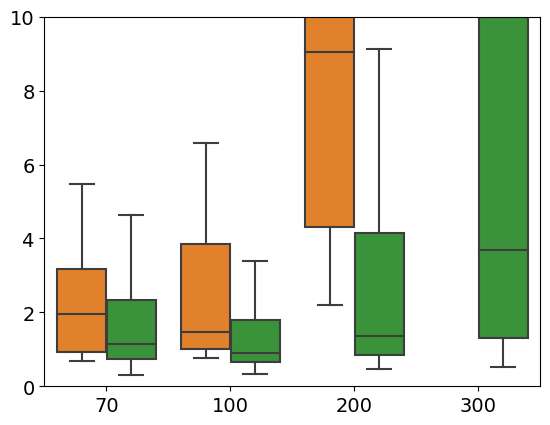

In [15]:
zoomed_df = formatted_df[formatted_df.model.isin(['FrameDiff', 'RFDiffusion'])]
order = ['FrameDiff', 'RFDiffusion']
ax = sns.boxplot(
    x = 'length',
    y = 'rmsd',
    data = zoomed_df,
    hue = 'model',
    hue_order=order,
    showfliers = False,
    palette = ['#ff7f0e', '#2ca02c']
)
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.ylim(0.0, 10)
legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
legend.remove()

# Clustering analysis

In [10]:
file = os.path.join(sample_cluster_dir, 'all_by_all_lite')
with open(file, 'r') as f:
    text = f.read()
    
    size = re.findall(r'SIZE :(.*\d+)', text)[0]
    size = int(size)
    
    id_to_filename = {}
    D = np.ones((size,size))
    for line in text.splitlines():
        if line[:3] == 'PDB':
            _, id_, filename = line.split()
            id_ = int(id_)
            id_to_filename[id_] = filename
        elif line[:2] == 'MS':
            _, _, idx1, idx2, tm1, tm2, pairs = line.split()
            i, j = int(idx1)-1, int(idx2)-1
            tm1, tm2 = float(tm1), float(tm2)
            tm_mean = (tm1 + tm2) / 2
            D[i, j] = 1 - tm1
            D[j, i] = 1 - tm2
D_mean = (D + D.T) / 2
    

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


<Figure size 200x200 with 0 Axes>

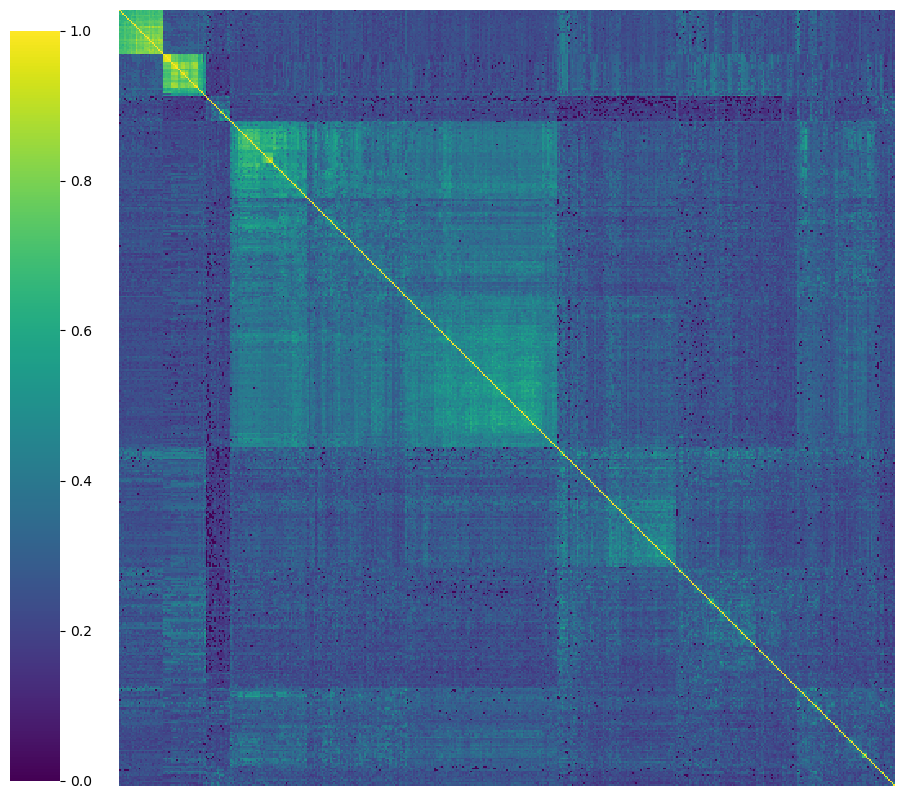

In [25]:
plt.figure(figsize=(2,2))
g = sns.clustermap(
    1 - D_mean,
    method='average',
    figsize=(10,10),
    yticklabels=False,
    xticklabels=False,
    cbar_pos=(0.1, 0.02, 0.05, 0.75),
    cmap='viridis'
)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
plt.show()
# plt.savefig(os.path.join(figure_dir, 'unconditional_sample_clustering.png'))

In [177]:
tm_score_similarities = np.triu(1 - D_mean, k=1)
pairwise_similarities = tm_score_similarities[np.where(tm_score_similarities)]

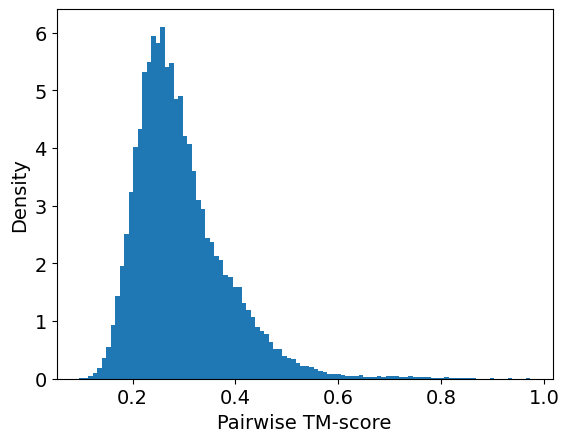

In [183]:
_ = plt.hist(pairwise_similarities, bins=100, density=True)

plt.xlabel('Pairwise TM-score')
plt.ylabel('Density')
plt.show()

# Align samples to training PDBs

### Save traiing PDBs

In [ ]:
def int_to_chain(i,base=62):
    """
    int_to_chain(int,int) -> str
    Converts a positive integer to a chain ID. Chain IDs include uppercase
    characters, numbers, and optionally lowercase letters.
    i = a positive integer to convert
    base = the alphabet size to include. Typically 36 or 62.
    """
    if i < 0:
        raise ValueError("positive integers only")
    if base < 0 or 62 < base:
        raise ValueError("Invalid base")

    quot = int(i)//base
    rem = i%base
    if rem < 26:
        letter = chr( ord("A") + rem)
    elif rem < 36:
        letter = str( rem-26)
    else:
        letter = chr( ord("a") + rem - 36)
    if quot == 0:
        return letter
    else:
        return int_to_chain(quot-1,base) + letter

class OutOfChainsError(Exception): pass
def rename_chains(structure):
    """Renames chains to be one-letter chains
    
    Existing one-letter chains will be kept. Multi-letter chains will be truncated
    or renamed to the next available letter of the alphabet.
    
    If more than 62 chains are present in the structure, raises an OutOfChainsError
    
    Returns a map between new and old chain IDs, as well as modifying the input structure
    """
    next_chain = 0 #
    # single-letters stay the same
    chainmap = {c.id:c.id for c in structure.get_chains() if len(c.id) == 1}
    for o in structure.get_chains():
        if len(o.id) != 1:
            if o.id[0] not in chainmap:
                chainmap[o.id[0]] = o.id
                o.id = o.id[0]
            else:
                c = int_to_chain(next_chain)
                while c in chainmap:
                    next_chain += 1
                    c = int_to_chain(next_chain)
                    if next_chain >= 62:
                        raise OutOfChainsError()
                chainmap[c] = o.id
                o.id = c
    return chainmap

def cif_to_pdb(cif_path, pdb_path):
    #Not sure why biopython needs this to read a cif file
    strucid = cif_path[:4] if len(cif_path)>4 else "1xxx"

    # Read file
    parser = MMCIFParser()
    structure = parser.get_structure(strucid, cif_path)
    
    # rename long chains
    try:
        chainmap = rename_chains(structure)
    except OutOfChainsError:
        logging.error("Too many chains to represent in PDB format")
        sys.exit(1)

    #Write PDB
    io = PDBIO()
    io.set_structure(structure)
    #TODO What happens with large structures?
    io.save(pdb_path)

In [ ]:
# Create fake experiment with the data setting used for the checkpoint experiment.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 0
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False

# Data settings
data_conf = conf.data

# Create experiment object to extract training CSV.
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader, _ = exp.create_rosetta_dataset(0, 1)
train_csv = train_loader.dataset.csv

# Save all training examples to PDB
train_pdbs_list = os.path.join(train_align_dir, 'train_pdbs.txt')
with open(train_pdbs_list, 'w') as f:
    for cif_path in train_csv.raw_path.tolist():
        pdb_path = os.path.join(save_dir, os.path.basename(cif_path)).replace('.cif', '.pdb')
        if not os.path.exists(pdb_path):
            cif_to_pdb(cif_path, pdb_path)
        f.write(pdb_path+'\n')
        
# Go outside of notebook and create database.

### Read alignments

In [66]:
def process_lines(line):
    cleaned_lines = line.replace('\n', '')
    pdb_name, tm_score = cleaned_lines.split(' ')
    return pdb_name, float(tm_score)

In [92]:
all_results = defaultdict(list)
for x in os.listdir(train_align_dir):
    output_path = os.path.join(train_align_dir, x)
    if 'tar.gz' in output_path:
        print(output_path)
        continue
    with open(output_path) as f:
        for i,line in enumerate(f):
            # try:
            l = process_lines(line)
            all_results[x].append(l)
            # except Exception as e:
            #     print(output_path, e)
            #     continue

/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_3/train_align/results.tar.gz


In [19]:
subset_df = hallucination_sc_df[hallucination_sc_df.tm_score >= 0.5]

In [20]:
len(subset_df)

475

In [69]:
alignment_df = {
    'length': [],
    'sample_id': [],
    'top_hit': [],
    'top_hit_score': []
}
for example_id, example_alignments in all_results.items():
    length = int(example_id.split('_')[1])
    sample_id = int(example_id.split('_')[-1])
    alignment_df['length'].append(length)
    alignment_df['sample_id'].append(sample_id)
    top_hit, top_hit_score = example_alignments[0]
    alignment_df['top_hit'].append(top_hit)
    alignment_df['top_hit_score'].append(top_hit_score)
alignment_df = pd.DataFrame(alignment_df)

In [70]:
aligned_df = subset_df.merge(alignment_df, on=['length', 'sample_id'])

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 71 rows containing missing values.


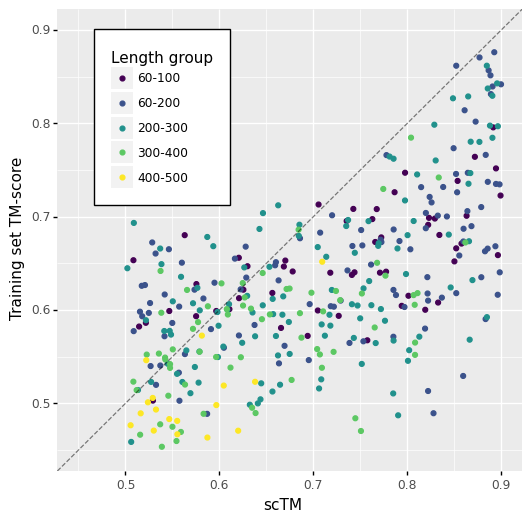

In [23]:
# Plot
p = (
    gg.ggplot(
        aligned_df,
        gg.aes('tm_score', 'top_hit_score', color='length_group')
    )
    + gg.geom_point()
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Training set TM-score')
    + gg.labels.labs(color='Length group')
    + gg.scales.ylim(0.45, 0.90)
    + gg.scales.xlim(0.45, 0.90)
    + gg.themes.theme(
        figure_size=(6, 6),
        legend_position=(0.3, 0.7),
        legend_background=gg.themes.element_rect(fill='white', color='black')
    )
    + gg.geom_abline(
        gg.aes(intercept=0.0, slope=1.0),
        linetype='dashed',
        alpha=0.5
    )
)

print(p)

In [18]:
len(list(range(60, 505, 5))) * 10

89

In [24]:
# Save out the figure
fig_path = os.path.join(figure_dir, 'unconditional_training_set_comparison.png')
p.save(filename=fig_path, dpi=300)

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 6 in image.
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_3/figures/unconditional_training_set_comparison.png
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 71 rows containing missing values.


In [ ]:
# Look at the most novel folds.
# aligned_df.sort_values('tm_score', ascending=False).sort_values('top_hit_score', ascending=True).head(20)
aligned_df.sort_values('top_hit_score', ascending=True).head(20)

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 71 rows containing missing values.


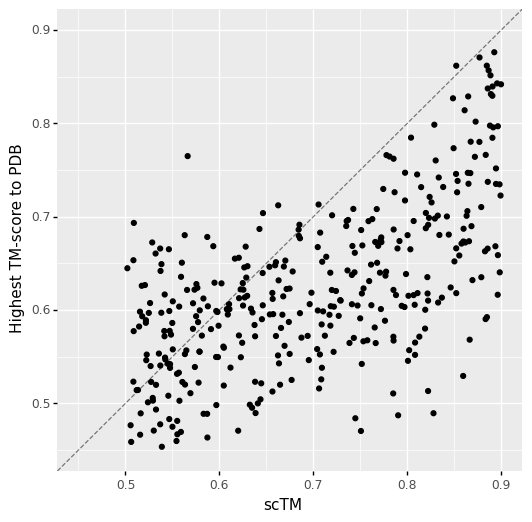

In [75]:
# Plot
p = (
    gg.ggplot(
        aligned_df,
        gg.aes('tm_score', 'top_hit_score')
    )
    + gg.geom_point()
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Highest TM-score to PDB')
    # + gg.labels.labs(color='Length')
    + gg.scales.ylim(0.45, 0.90)
    + gg.scales.xlim(0.45, 0.90)
    + gg.themes.theme(
        figure_size=(6, 6),
        legend_position=(0.3, 0.7),
        legend_background=gg.themes.element_rect(fill='white', color='black')
    )
    + gg.geom_abline(
        gg.aes(intercept=0.0, slope=1.0),
        linetype='dashed',
        alpha=0.5
    )
)

print(p)

# Link clusters with PDB similarity

In [193]:
with open('/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_3/sample_clustering/maxcluster_results.txt', 'r') as f:
    capture = False
    centroid_lines = []
    for line in f.read().splitlines():
        if capture:
            centroid_lines.append(line)
        if 'INFO  : Cluster  Centroid  Size        Spread' in line:
            capture = True
            
centroid_lines = centroid_lines[:-1]

data = {'Cluster size': [], 'path': [], 'length': [], 'sample_id': []} #, 'tm_v_pdb100': []}
for line in centroid_lines:
    line = line.split()
    cluster_size = line[5]
    path = line[7]
    filename = os.path.basename(path).replace('.pdb', '')
    data['Cluster size'].append(int(cluster_size))
    data['path'].append(path)
    data['length'].append(int(filename.split('_')[1]))
    data['sample_id'].append(int(filename.split('_')[3]))

clusters_df = pd.DataFrame(data)

In [197]:
centroid_df = aligned_df.merge(clusters_df, on=['length', 'sample_id'])

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 22 rows containing missing values.


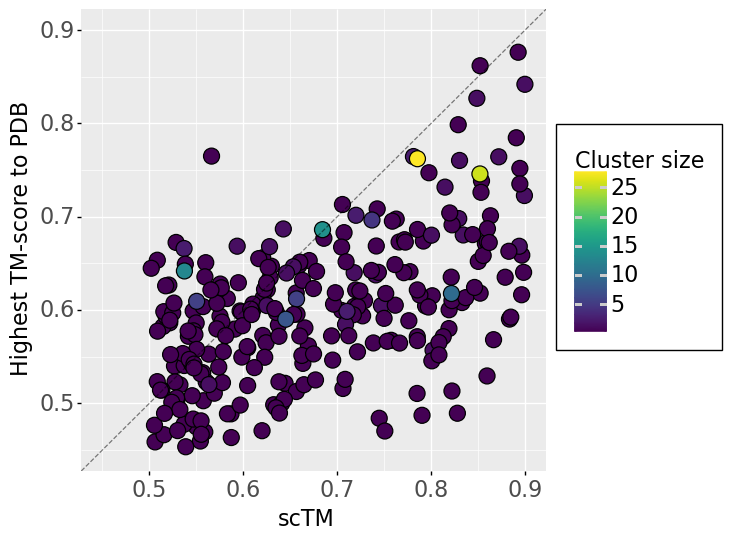

In [196]:
# Plot
p = (
    gg.ggplot(
        centroid_df,
        gg.aes('tm_score', 'top_hit_score', fill='Cluster size')
    )
    + gg.geom_point(size=6)
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Highest TM-score to PDB')
    # + gg.labels.labs(color='Length')
    + gg.scales.ylim(0.45, 0.90)
    + gg.scales.xlim(0.45, 0.90)
    + gg.themes.theme(
        figure_size=(6, 6),
        # legend_position=(0.3, 0.7),
        legend_background=gg.themes.element_rect(fill='white', color='black'),
        text=gg.element_text(size=16)
    )
    + gg.geom_abline(
        gg.aes(intercept=0.0, slope=1.0),
        linetype='dashed',
        alpha=0.5
    )
)

print(p)

In [205]:
# Save out the figure
fig_path = os.path.join(figure_dir, 'centroid_tm.png')
p.save(filename=fig_path, dpi=300)

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 6 in image.
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_3/figures/centroid_tm.png
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 22 rows containing missing values.


In [206]:
figure_dir

'/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_3/figures'

In [209]:
centroid_df[(centroid_df['tm_score'] > 0.8) & (centroid_df['top_hit_score'] < 0.52)]

,length,sample_id,Post-ProteinMPNN,tm_score,sample_path,header,sequence,rmsd,length_group,designable,top_hit,top_hit_score,Cluster size,path
140,190,2,True,0.822135,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/13D_12M_2022Y_00h_05m_46s/length_190/sample_3/mpnn/esmf/sample_10.pdb,"T=0.1, sample=10, score=0.9617, global_score=0.9617, seq_recovery=0.2211",MGYADALLYKEEISKAIIEACKEYVASGKPEPGTLLGGPHEEKVKIWTALWEKIKPKLKHLPEAGFKAIEKAILSSKDVGTAEEIVEKGFELWDEEGRKELTEAPDDLDCPRSVVVAAVALVEAAAAAAAGRGDGLPGAAAATAAVLAVAAAACSAADGARLAALVYLAGMGYGLGRPEIAELAKARLLA,2.595973,60-200,True,2yev_A,0.51321,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_3/samples/length_190_id_2.pdb
141,190,6,True,0.827916,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/13D_12M_2022Y_00h_05m_46s/length_190/sample_1/mpnn/esmf/sample_8.pdb,"T=0.1, sample=8, score=0.8848, global_score=0.8848, seq_recovery=0.2684",LGPELLALLGATLTPDPEEWARRTADPDSLRRIGLAFVAAAFVEIAAAEGRDPAQADADMEAFLAAMRGAIPLEEVEALLRAALEGPWGERARRGTPEGQRDFAAVLVIVGVGLACNAPDAAAVFAEGAELARAGLAGWRAAPAHPALETARAAAEGFRAAVAAGDPALGRETLEALLARGRALIERGEA,2.756346,60-200,True,5iau_A,0.48940,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_3/samples/length_190_id_6.pdb


In [201]:
centroid_df.sort_values('tm_score', ascending=False).sort_values('top_hit_score')

,length,sample_id,Post-ProteinMPNN,tm_score,sample_path,header,sequence,rmsd,length_group,designable,top_hit,top_hit_score,Cluster size,path
286,450,8,True,0.506338,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/14D_12M_2022Y_10h_22m_16s/length_450/sample_2/mpnn/esmf/sample_3.pdb,"T=0.1, sample=3, score=0.9849, global_score=0.9849, seq_recovery=0.2467",DGSDRWARLVREAAALPGAAAGAALALAGKAGAFAWGAAPAPAATAALAAIAAAGATTDAAGGAAAAGAAGAAAAVGLAIGRLPGPGAAVGLLGGGAGGALALAAAGGTPLDLADALAARRFGPRVRPALAVRALAAAALGVGVAAAAGDAFAAVWARLAAVTTPEEREAAYFALADEALEVARAGAAAAAADPTALGAAGALALTRVPGLLIGRGLLGDLVKIKEIAEEVKKYPGGGLMVTLSRSGPLNLKLTKLLLKEIEKEGVKIKAIYVVLGGSSGGGLPGCEFDALALLAQAKGGGGVIVLVGGGYDLAPAALELKEWGEKHGFEVKVYIVNNSDPTLLEKFGVENPILAWGKSIPPGYERLKTRYAVKKAIEDAIEKGIGVKIGAGFGLVPGDAATCKAEYEKVKKLTPNNKKIETLNPATFGACFAGGSPEEALAGYAEVEKA,13.619076,400-500,True,3wfz_A,0.40985,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_3/samples/length_450_id_8.pdb
277,415,6,True,0.510521,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/14D_12M_2022Y_10h_22m_16s/length_415/sample_1/mpnn/esmf/sample_10.pdb,"T=0.1, sample=10, score=1.0314, global_score=1.0314, seq_recovery=0.1831",TWPDVATAMKTLEENIAKAEKELEAAYKWLKESKFEFKDAVEAGKWYRENAPIITSLVLGYSARLARRALAIGAEDPRLFPGGLALAATGFLDAIIEALILKECLPELADKWKWEADAKAMLEALGALGRAFAELGKPVDNIVYIHNLAHAALGFERLQIDGLGVRKTPEKVPVLDPAEGLAAMDRLAVGEYTGREAALRYAPGVTYATALVSAGALPGLLAIASLIAGGGKVILITGATGLGKIVSEHAKSLGIEALWVPGPEFEALGYKAAPDENTLEKAIEKIKEGKKTGIVFGANAGGPPWRPAGPETKFLAAVNKLAREAGAGFAYDFAGEPIGATGDAPTPEEAALWREGAGPDLPEISGCGPAAEALAAAVGGELGGEEGCAPSEEERAELLARGDEALRRKLEEIVG,10.756716,400-500,True,6qub_A,0.43767,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_3/samples/length_415_id_6.pdb
265,380,0,True,0.512997,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/13D_12M_2022Y_13h_43m_13s/length_380/sample_9/mpnn/esmf/sample_5.pdb,"T=0.1, sample=5, score=1.0025, global_score=1.0025, seq_recovery=0.1842",GPPGVAAPRVIGVGVGPGEDWVAELLAGAAAEVEVLAAPDSLVGGLGAAAVLRALGEARGPEWLGRVGLLLPRNLDTAVGEDPAPAREAVRAALEVVAAGGLGVTLFGGRNVHAGADESGYEAALAEALAEAEADLARVFGGLDGGVTIVVGIGYGADGIDSEGVIGMGGQLATGEASRIALEEIARRAGARGLPRVLVVNGAGTGAGGVYAAALALESATVPEYGKIGRDTVGAGAIAAQVESRFEGPEYFPGGPGGGAENGRHGGVYLGRGERGLTPEECANIEAFLAGAKGGLDGWRERLLRFAAEGKLGGGLVVAGPGGGDDPAFRAARRAAALAAFGHLVATKDKPPEEANKSPMYGIGVGCAGHRRIPVYRALR,11.155926,300-400,True,3izx_A,0.44310,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_3/samples/length_380_id_0.pdb
290,500,3,True,0.518071,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/15D_12M_2022Y_19h_45m_23s/length_500/sample_7/mpnn/esmf/sample_10.pdb,"T=0.1, sample=10, score=0.9913, global_score=0.9913, seq_recovery=0.1940",APGAVGLAIGVAAGFGGGSGGVAAAGLAVWAWRERRADFGRLAAVVGLVAGLVGALAAGLGGALLLLAVAAGWWWPLVVVGLLGIVLGVLVGAVCVAIARRGPSPATLPVLVLIYILGMAFFGGGAVLLPWLLWALFRPVTGWAGLLLFLLTLLYALALLLLPLVALFGIAHLAVILLGLIFGLFGAGLTDAGLWLPVGFALAGGFGGALGAAGFAGGVAGLVGLGAERLPLAARRPLDLLAFLGLGAGLGIGFLGLGVIVGGAGAIVGHGIRAGIGPLTAVLAWAVLALATLLGLLVPVASVVLALLALLGRRDPAAGAVAGLALLLGGLLLLPLVVLSVVVTTAAGLISAGLAVVVGVVFTLLVLVAGVALAALLTGPARVAALLVGLVAGVAALGAGLLGVAGRLLARGVPGARGRDARGVVAGLGGILGLLGALLAGLLAGLLAGLLLALGGLPLLGGASGWGAVLWCLAGALVTAVGVLLVAAALVVVTLLDLLG,10.384461,60-100,True,6m32_A,0.44479,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_3/samples/length_500_id_3.pdb
249,330,1,True,0.538736,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/13D_12M_2022Y_13h_43m_13s/length_330/sample_2/mpnn/esmf/sample_1.pdb,"T=0.1, sample=1, score=0.9826, global_score=0.9826, seq_recovery=0.1364",AAGAPGEAAMDAAARAVLDGLLNGRIISEEVGGEALKEYYKKKDKNFDFSEYKGKKKGTLKDIIKAAEEEGKKVKDEGNPYGAVVRGMVAYIKKIDPRGAGLVVFGALANRLRELGGPVIVLNVGGPGGIGRGGREGVEAVAGVTLEKEGGAPGPEVGGDDGAFPATNVETYPGYIGIAGTGKLPEDNPAHPAEEEAKRQEAAAEKNVETHGIPGGFGWGNFGGSPPGENGLGVGVCPKETPLEKMPEAAKKHGVKKVVFVCIDVDYVCCIKIGQAVKDKGVVLVVIGAAGTVAEGAKRAGSTEPPANFGGGGGGGGGAAAARAAIARLE,10.176107,300-400,True,4ofz_A,0.45348,1,/data/rsg/che